In [1]:
from windrose import WindroseAxes
from matplotlib import pyplot
import matplotlib.cm as cm
import requests
import numpy
from dotenv import dotenv_values
from datetime import date, timedelta
from time import sleep
import csv

ECOWITT_DEVICE_ID = "58371"
START_DATE = date(2021, 8, 22)
END_DATE = date.today()

In [2]:
config = dotenv_values(".env")
req_ses = requests.session()
req_ses.post('https://webapi.www.ecowitt.net/user/site/login', data={'account':config.get('USER'), 'password': config.get('PASSWORD'), "authorize": ""})

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def payload(sdate, edate):
    return  {
        'device_id': ECOWITT_DEVICE_ID,
        'is_list': '0',
        'mode': '0',
        'sdate': sdate,
        'edate': edate,
        'page': '1',
        'sortList': '0|2|3|4|5|24|999',
        'hideList': ''
    }

def normalize_calm(entry):
    """Change anything below 3mph to calm"""
    if entry[1] < 3:
        return (0,0.0)
    return entry

all_data = []

for day in daterange(START_DATE, END_DATE):
    d = req_ses.post('https://webapi.www.ecowitt.net/index/get_data', data=payload(day.strftime("%Y-%m-%d 00:00"), day.strftime("%Y-%m-%d 23:59"))).json()
    dimensions = d.get('list')
    wind_speed = dimensions.get("wind_speed").get("list").get("windspeedmph")
    wind_dir = dimensions.get("winddir").get("list").get("winddir")
    times = d.get("times")
    all_data.extend([(x[0], x[1], float(x[2])) for x in list(zip(times,wind_dir,wind_speed)) if x[1] != "" and x[2] != ""])
    sleep(0.5)

with open(f'data/{START_DATE.strftime("%Y%m%d")}-{END_DATE.strftime("%Y%m%d")}.csv', 'w') as fd:
    write = csv.writer(fd)
    write.writerows(all_data)

wd = numpy.array([x[1] for x in all_data])
ws = numpy.array([x[2] for x in all_data])


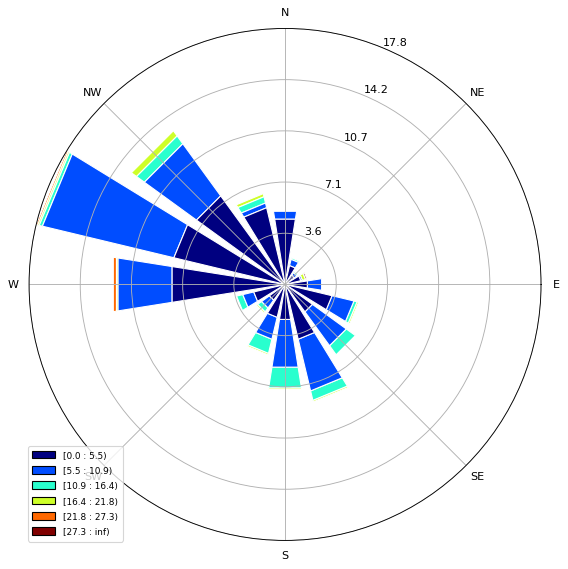

In [3]:
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_xticklabels(['E', 'NE','N', 'NW', 'W', 'SW', 'S', 'SE'])
ax.set_legend()
